In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')

In [2]:
# Подключаемся к БД, содержащей данные для заданий:
con = sqlite3.connect('/content/drive/MyDrive/Тестовые/MTC.db')

In [3]:
def select(sql):
  return pd.read_sql(sql, con)

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Тестовые/Данные заданий от МТС/interactions.csv')
items = pd.read_csv('/content/drive/MyDrive/Тестовые/Данные заданий от МТС/items.csv')
users = pd.read_csv('/content/drive/MyDrive/Тестовые/Данные заданий от МТС/users.csv')

In [5]:
df.to_sql('interactions', con, index=False, if_exists='replace')
items.to_sql('items', con, index=False, if_exists='replace')
users.to_sql('users', con, index=False, if_exists='replace')

840197

### 1. Используй данные, которые у нас имеются, и проведи их анализ.<br> Обрати особое внимание на такие параметры как тип контента<br> (колонка content_type в файле items.csv), продолжительность<br> просмотра (колонка total_dur в файле interactions.csv) для определения<br> метрики осознанного смотрения. Каких клиентов можно считать осознанно смотрящими?<br> Напиши SQL запрос для объединения данных, которые рассредоточены по нескольким таблицам.

Осознанно смотрящими зрителями будем считать тех, кто <br>
посмотрел более 60 мин фильма(т.е. в среднем, более половины)<br>
или 35 минут сериала (тоже, в среднем, более половины серии)

In [6]:
sql = """ select
                i.user_id as user_id,
                i.total_dur as total_dur,
                it.content_type as content_type,
                CASE
                WHEN it.content_type = 'film' and i.total_dur > 65 then 'active_viewer'
                WHEN it.content_type = 'series' and  i.total_dur > 35 then 'active_viewer'
                ELSE 'rare_viewer'
                END as 'category_viewer'
           from interactions as i
           left join items as it on i.item_id = it.item_id
           group by user_id
           order by total_dur desc"""

In [7]:
select(sql)

,user_id,total_dur,content_type,category_viewer
0,797869,6147245,series,active_viewer
1,245556,3502510,series,active_viewer
2,608062,2558481,series,active_viewer
3,55488,2527356,series,active_viewer
4,586337,2519805,series,active_viewer
...,...,...,...,...
962174,878,1,series,rare_viewer
962175,368,1,film,rare_viewer
962176,351,1,film,rare_viewer
962177,174,1,film,rare_viewer


In [8]:
viewers = select(sql)

In [9]:
rare = viewers.loc[viewers['category_viewer'] == 'rare_viewer']

In [12]:
rare.head()

,user_id,total_dur,content_type,category_viewer
792286,1096250,65,film,rare_viewer
792287,1096153,65,film,rare_viewer
792288,1096103,65,film,rare_viewer
792289,1095986,65,film,rare_viewer
792290,1092654,65,film,rare_viewer


In [13]:
rare.groupby('content_type', as_index=False)\
       .agg({'total_dur': ['mean', 'median']}).round(2)

content_type total_dur       
                    mean median
0         film     23.59   19.0
1       series     14.57   13.0

Т.о. редкий зритель смотрит в среднем 20-23 минуты фильма<br>
или около 15 минут сериала.

## 2. Какой контент является самым популярным среди пользователей с детьми?

In [14]:
sql = """ select count(distinct i.user_id) as users_cnt,
                 sum(total_dur) as total_sum_dur,
                 round(avg(total_dur), 1) as avg_dur,
                 content_type
          from interactions as i
          join users as u on i.user_id = u.user_id
          join items as it on i.item_id = it.item_id
          where u.kids_flg = 1
          group by it.content_type """

In [15]:
select(sql)

,users_cnt,total_sum_dur,avg_dur,content_type
0,191490,5152405397,4532.2,film
1,133679,6541988847,20087.7,series


Таким образом, большая часть зрителей с детьми предпочитают<br> смотреть фильмы. Однако, по суммарно затраченному времени<br> просмотра, больше времени уходит на просмотры сериалов.<br>
В среднем,на просмотр сериалов тратится времени больше.<br>

Следовательно, сериалы являются более популярным контентом.

In [16]:
sql = """ select count(distinct i.user_id) as users,
                 title, content_type
          from interactions as i
          left join users as u on i.user_id = u.user_id
          join items as it on i.item_id = it.item_id
          where u.kids_flg = 1
          group by  title
          order by users desc limit 10 """

Найдем 10 наиболее просматриваемых фильмов/сериалов<br> по количеству пользователей.


In [17]:
select(sql)

,users,title,content_type
0,46559,Хрустальный,series
1,43236,Клиника счастья,series
2,38393,Гнев человеческий,film
3,37428,Девятаев,film
4,22672,Секреты семейной жизни,series
5,21306,Прабабушка легкого поведения,film
6,15417,Афера,series
7,13184,Подслушано,series
8,12485,Маша,film
9,11492,Белый снег,film


In [18]:
top_views = select(sql)
top_views.head()

,users,title,content_type
0,46559,Хрустальный,series
1,43236,Клиника счастья,series
2,38393,Гнев человеческий,film
3,37428,Девятаев,film
4,22672,Секреты семейной жизни,series


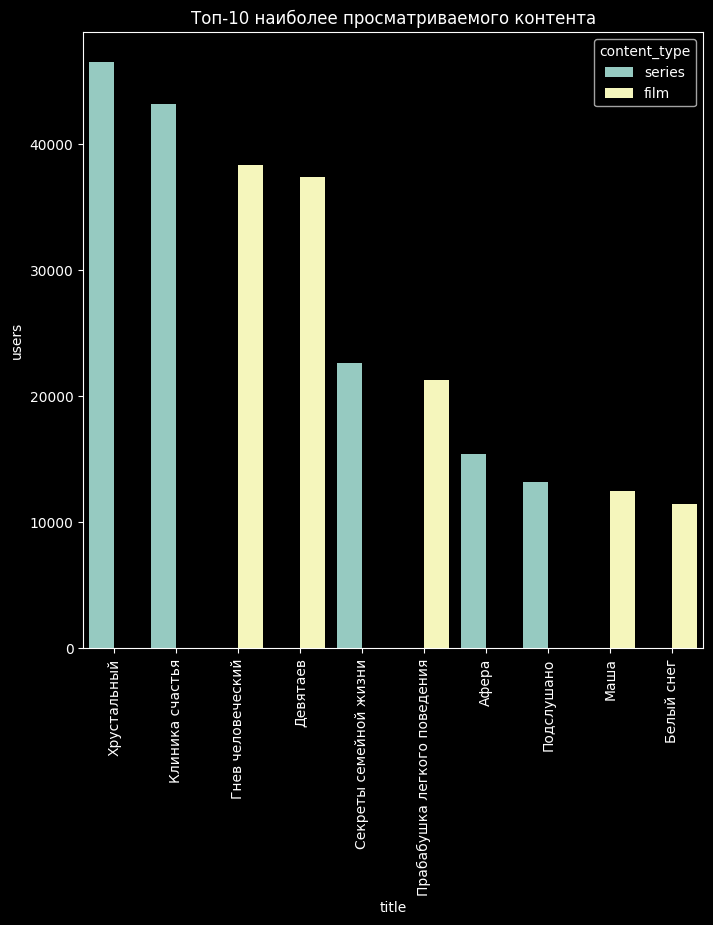

In [19]:
plt.figure(figsize=(8, 8))
sns.barplot(data=top_views, x='title', y='users', hue='content_type')
plt.xticks(rotation=90)
plt.title('Топ-10 наиболее просматриваемого контента')
plt.show()

## 3. Какой контент относится к наименее просматриваемому?

In [20]:
sql = """ select count(distinct i.user_id) as users,
                 title, content_type
          from interactions as i
          left join items as it on i.item_id = it.item_id
          where title not like '%(жестовым языком)%' and title != '#яздесь (с тифлокомментарием)'
          group by  title
          order by users asc limit 10 """

In [21]:
# Выведем 10 наименее просматриваемых наименований:

select(sql)

,users,title,content_type
0,1,#ЯЗДЕСЬ,film
1,1,10 самых,series
2,1,1000 Секретов Развития Силы,series
3,1,12 мелодий любви,film
4,1,300 лет одиночества,film
5,1,4:0 в пользу Танечки,film
6,1,Abdulaziz Salavat,series
7,1,Ador Player,series
8,1,Aikoland - TV Канал о рыбалке,series
9,1,Alex Tubefun,series
